***Shopper Spectrum – Customer Segmentation & Product Recommendation***

Problem Statement

The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth. This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.


🔹 1. INSTALL & IMPORT LIBRARIES

In [1]:
!pip install streamlit scikit-learn seaborn plotly joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import warnings
warnings.filterwarnings('ignore')


🔹 2. DATASET LOADING & UNDERSTANDING

In [3]:
df = pd.read_csv('/content/online_retail.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129314 entries, 0 to 129313
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    129314 non-null  object 
 1   StockCode    129314 non-null  object 
 2   Description  128953 non-null  object 
 3   Quantity     129314 non-null  int64  
 4   InvoiceDate  129314 non-null  object 
 5   UnitPrice    129314 non-null  float64
 6   CustomerID   87620 non-null   float64
 7   Country      129313 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 7.9+ MB


,Quantity,UnitPrice,CustomerID
count,129314.000000,129314.000000,87620.000000
mean,8.890986,5.240391,15305.957350
std,297.155226,109.483500,1736.278931
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13904.000000
50%,3.000000,2.460000,15235.000000
75%,10.000000,4.210000,16891.000000
max,74215.000000,16888.020000,18283.000000


In [5]:
df.isnull().sum()
df.duplicated().sum()


np.int64(1156)

🔹 3. DATA PREPROCESSING

In [6]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove zero or negative Quantity & UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Total Amount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df.shape


(85392, 9)

🔹 4. EXPLORATORY DATA ANALYSIS (EDA)


 Transactions by Country

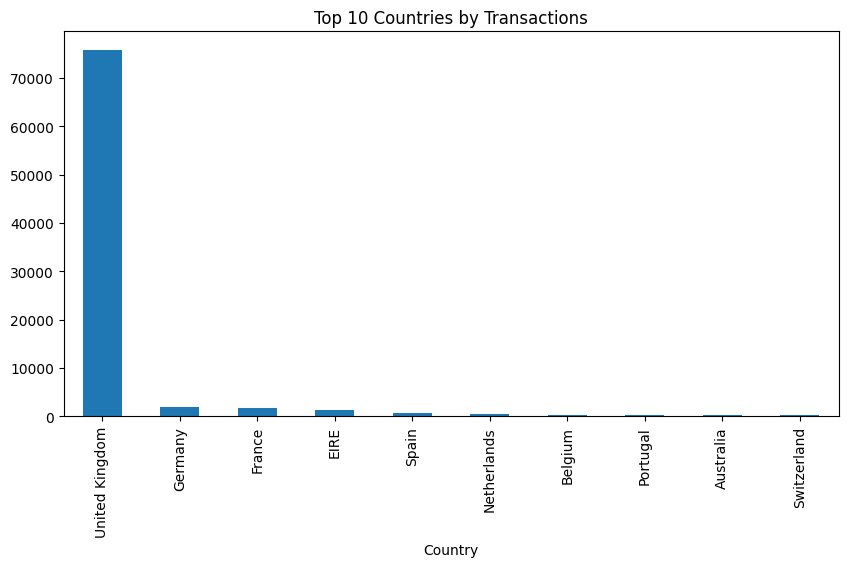

In [7]:
plt.figure(figsize=(10,5))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Transactions")
plt.show()


Top Selling Products

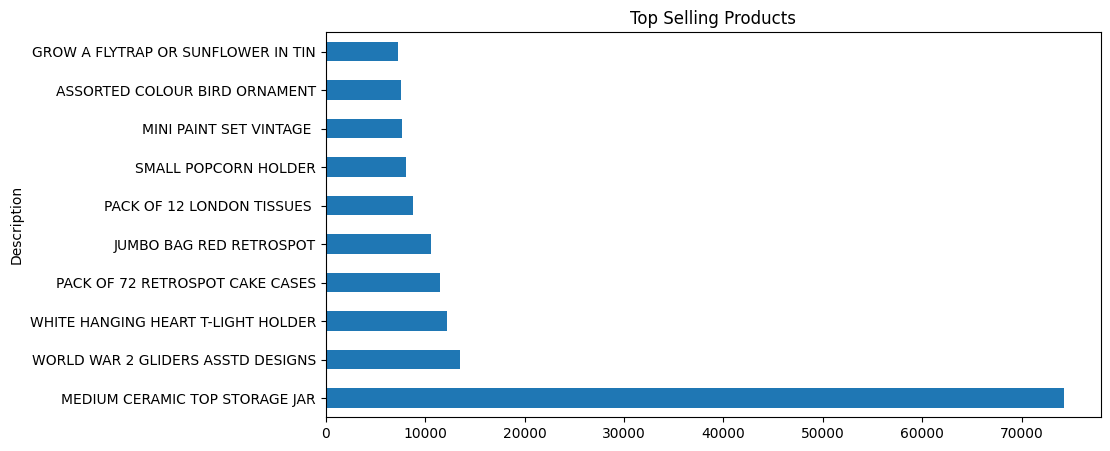

In [8]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10,5))
plt.title("Top Selling Products")
plt.show()


Purchase Trend Over Time

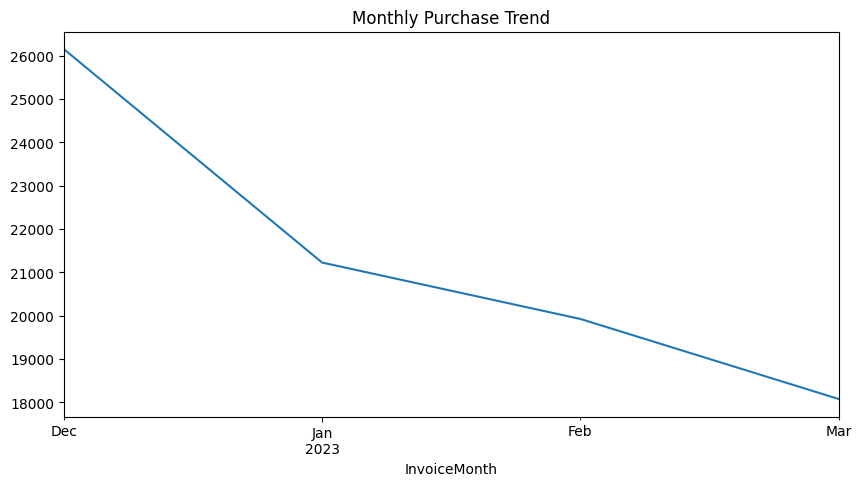

In [9]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df.groupby('InvoiceMonth')['InvoiceNo'].count().plot(figsize=(10,5))
plt.title("Monthly Purchase Trend")
plt.show()


Monetary Distribution

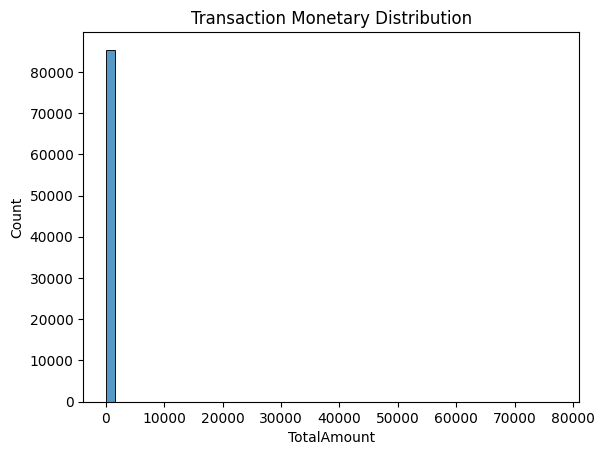

In [10]:
sns.histplot(df['TotalAmount'], bins=50)
plt.title("Transaction Monetary Distribution")
plt.show()


🔹 5. RFM FEATURE ENGINEERING

In [11]:
latest_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,63,1,77183.60
1,12347.0,55,60,1187.18
2,12348.0,56,23,1120.24
3,12350.0,47,17,334.40
4,12352.0,4,30,1401.48


RFM Distributions

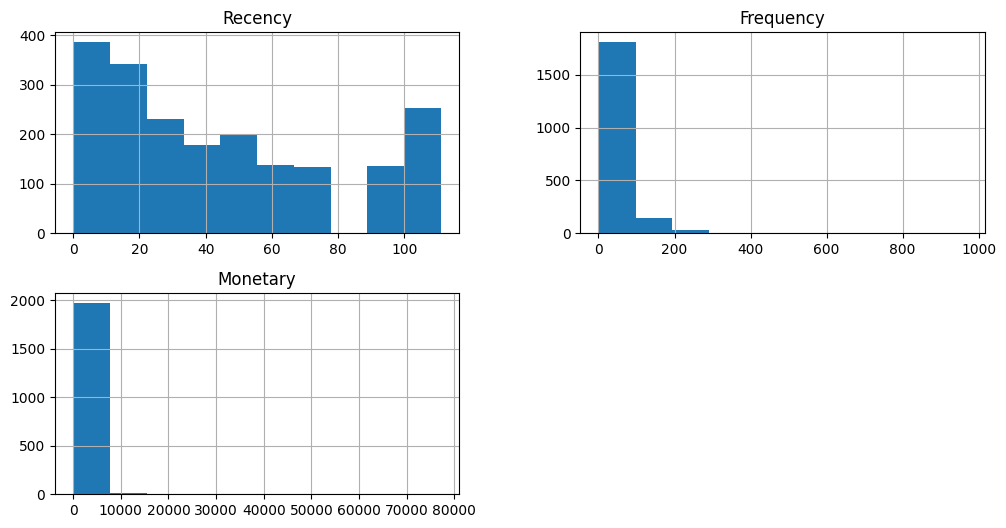

In [12]:
rfm[['Recency','Frequency','Monetary']].hist(figsize=(12,6))
plt.show()


🔹 6. RFM SCALING

In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])


🔹 7. CLUSTER SELECTION (ELBOW + SILHOUETTE)

Elbow Method

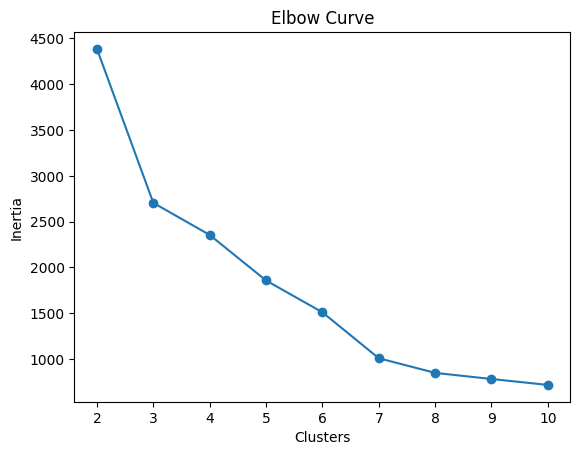

In [14]:
inertia = []
K = range(2,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()


Silhouette Score

In [15]:
for k in range(2,7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    print(f"K={k}, Silhouette Score={silhouette_score(rfm_scaled, labels):.3f}")


K=2, Silhouette Score=0.426
K=3, Silhouette Score=0.473
K=4, Silhouette Score=0.382
K=5, Silhouette Score=0.391
K=6, Silhouette Score=0.392


🔹 8. FINAL CLUSTERING (K=4)

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


Cluster Profiling

In [17]:
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
cluster_profile


,Recency,Frequency,Monetary
Cluster,,,
0,14.720088,55.160263,1076.552053
1,51.570796,25.172566,501.971770
2,12.476190,391.190476,24247.066190
3,102.276215,25.214834,369.759974


Segment Labeling

In [18]:
def label_cluster(row):
    if row['Frequency'] > rfm['Frequency'].median() and row['Monetary'] > rfm['Monetary'].median():
        return 'High-Value'
    elif row['Frequency'] > rfm['Frequency'].median():
        return 'Regular'
    elif row['Recency'] > rfm['Recency'].median():
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,63,1,77183.60,2,At-Risk
1,12347.0,55,60,1187.18,1,High-Value
2,12348.0,56,23,1120.24,1,At-Risk
3,12350.0,47,17,334.40,1,At-Risk
4,12352.0,4,30,1401.48,0,High-Value


🔹 9. CLUSTER VISUALIZATION

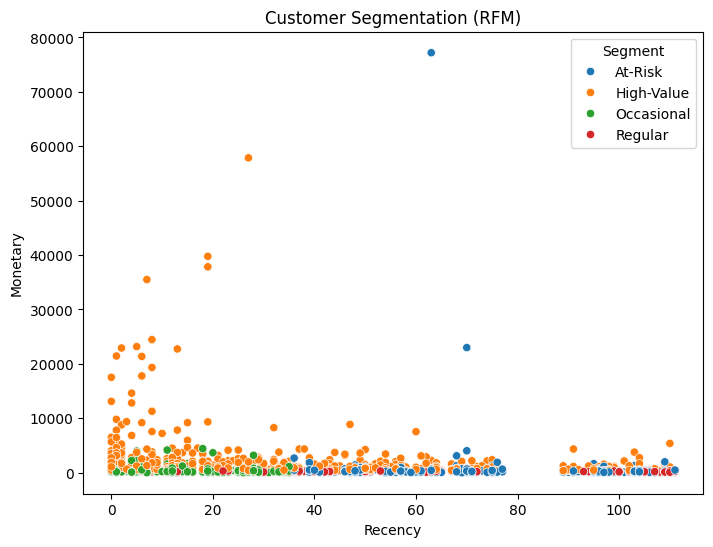

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm['Recency'],
    y=rfm['Monetary'],
    hue=rfm['Segment']
)
plt.title("Customer Segmentation (RFM)")
plt.show()


🔹 10. SAVE MODELS FOR STREAMLIT

In [20]:
joblib.dump(kmeans, 'kmeans_rfm_model.pkl')
joblib.dump(scaler, 'rfm_scaler.pkl')


['rfm_scaler.pkl']

🔹 11. PRODUCT RECOMMENDATION SYSTEM

Item-Based Collaborative Filtering

In [21]:
pivot = df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)


In [22]:
product_similarity = cosine_similarity(pivot.T)
product_sim_df = pd.DataFrame(
    product_similarity,
    index=pivot.columns,
    columns=pivot.columns
)


Heatmap

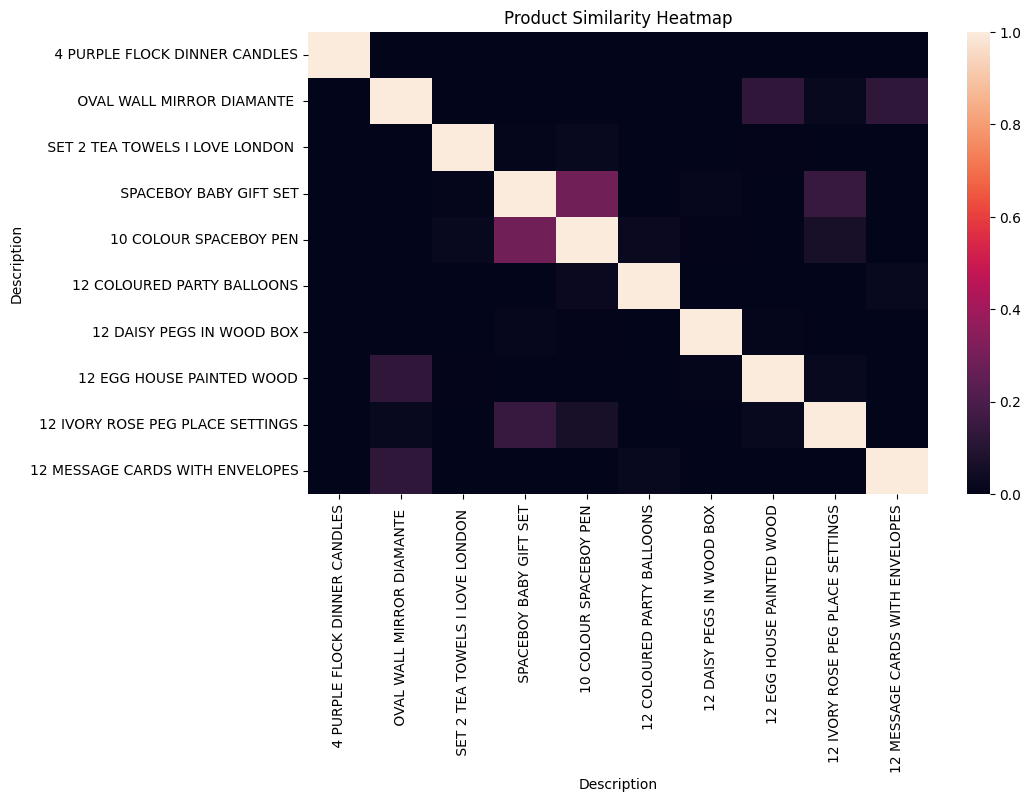

In [23]:
plt.figure(figsize=(10,6))
sns.heatmap(product_sim_df.iloc[:10,:10])
plt.title("Product Similarity Heatmap")
plt.show()


Recommendation Function

In [24]:
def recommend_products(product_name, n=5):
    if product_name not in product_sim_df:
        return []
    return (
        product_sim_df[product_name]
        .sort_values(ascending=False)
        .iloc[1:n+1]
        .index.tolist()
    )

recommend_products("WHITE HANGING HEART T-LIGHT HOLDER")


['GIN + TONIC DIET METAL SIGN',
 'DOORMAT FAIRY CAKE',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'TEA TIME TEA TOWELS ',
 'RED HANGING HEART T-LIGHT HOLDER']

🔹 12. STREAMLIT APP CODE (SAVE AS app.py)

In [25]:
!pip install streamlit pyngrok joblib scikit-learn pandas --quiet


In [26]:
import os
os.environ["NGROK_AUTHTOKEN"] = "38IiKOpZ9XVtEo8FWDyeoNXLPLV_87jk3kJhMzmN1GcMifxgG"


In [27]:
from pyngrok import ngrok
ngrok.set_auth_token(os.environ["NGROK_AUTHTOKEN"])


In [28]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import os

# ---------------- CONFIG ----------------
st.set_page_config(
    page_title="Shopper Spectrum",
    page_icon="🛒",
    layout="centered"
)

# ---------------- LOAD MODELS ----------------
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

kmeans = joblib.load(os.path.join(BASE_DIR, "kmeans_rfm_model.pkl"))
scaler = joblib.load(os.path.join(BASE_DIR, "rfm_scaler.pkl"))

# ---------------- UI ----------------
st.title("🛒 Shopper Spectrum")
st.caption("Customer Segmentation using RFM Analysis")

st.markdown("---")

st.header("👤 Customer Segmentation")

recency = st.number_input("Recency (Days since last purchase)", min_value=0)
frequency = st.number_input("Frequency (Total purchases)", min_value=0)
monetary = st.number_input("Monetary Value (Total spend)", min_value=0.0)

if st.button("Predict Customer Segment"):
    input_data = scaler.transform([[recency, frequency, monetary]])
    cluster = int(kmeans.predict(input_data)[0])

    segment_map = {
        0: "💎 High-Value Customer",
        1: "🙂 Regular Customer",
        2: "🛍️ Occasional Customer",
        3: "⚠️ At-Risk Customer"
    }

    st.success(f"Predicted Segment: {segment_map.get(cluster)}")


Overwriting app.py


In [29]:
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://26a4ab0845e3.ngrok-free.app" -> "http://localhost:8501">

In [ ]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &





  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

